# NHANES project about General Oral Health: descriptive and regression analysis
> This notebook has the purpose to collect all the analysis on Nhanes dataset for a medical paper project 

Requirements and Information:
1. Nhanes dataset from 2009/10 to 2013/14
2. 5 Intrinsic Capacity domains
    1. Locomotion:
        - Standingup from armless chair difficulty (PFQ061I)
    2. Cognitive Function:
        - Have serious difficulty concentrating (DLQ040)
    3. Vitality:
        - Weight change intentional (WHQ060)
        - Poor appetite or overeating (DPQ050)
    4. Psychological status:
        - Feeling down, depressed, or hopeless (DPQ020)
        - Have little interest in doing things (DPQ010)
    5. Sensory domain:
        - Have serious difficulty hearing? (DLQ010)
        - Have serious difficulty seeing? (DLQ020)
3. Exposure/Predictor:
    1. OHQ835 : {Do you/Does SP} think {you/s/he} might have gum disease?
    2. OHQ845 : Overall, how would {you/SP} rate the health of {your/his/her} teeth and gums?
    3. OHQ850 : Ever had treatment for gum disease?
    4. OHQ855 : Any teeth became loose without an injury
    5. OHQ860 : Ever been told of bone loss around teeth
    6. OHQ865 : Noticed a tooth that doesn't look right
    7. OHQ870 : How many days use dental floss/device
    8. OHQ875 : Days used mouthwash for dental problem
4. Confounding Variables:
    - Gender (RIAGENDR)
    - Age at screening (RIDAGEYR)
    - Race (RIDRETH1)
    - Education	(DMDEDUC2)
    - Poverty income ratio (INDFMPIR)
    - Smoking status (SMQ020)
5. Mediators:
    - Heart failure	(RIDRETH1)  
    - Coronary heart disease (MCQ160b)
    - Stroke (MCQ160c)
    - Liver disease	(MCQ160o)
    - Cancer (MCQ500)
    - Diabetes (MCQ220)
    - High blood pressure (DIQ010)
6. Age => 60

## NHANES 2013/14: Intrinsic Capacity and Global Oral Health

### Import Libraries

In [1]:
library(haven)
library(nhanesA)
library(survey)
library(MASS)
library(dplyr)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(readr)
library(flextable)
library(officer)
library(nnet)
library(broom)
library(ggplot2)
library(psych)

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: 'survey'


The following object is masked from 'package:graphics':

    dotchart



Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.5
v ggplot2   3.5.1     v stringr   1.5.1
v lubridate 1.9.4     v tibble    3.2.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stat

### Configurations

In [2]:
path_to_data_09_10 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2009_10/"
path_to_data_11_12 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2011_12/"
path_to_data_13_14 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2013_14/"

### Load Dataset & Feature Selection

In [3]:
# Datasets for 2009/10 period

demo_09_10 <- read_xpt(file.path(path_to_data_09_10, "DEMO_F.xpt"))

demo_09_10_selected <- demo_09_10 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_09_10 <- read_xpt(file.path(path_to_data_09_10, "ALQ_F.xpt"))

alcohol_09_10_selected <- alcohol_09_10 %>%
  select(SEQN, ALQ101)

smoking_09_10 <- read_xpt(file.path(path_to_data_09_10, "SMQ_F.xpt.txt"))

smoking_09_10_selected <- smoking_09_10 %>%
    select(SEQN, SMQ020)

med_conditions_09_10 <- read_xpt(file.path(path_to_data_09_10, "MCQ_F.xpt"))

med_conditions_09_10_selected <- med_conditions_09_10 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_09_10_selected <- med_conditions_09_10_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_09_10 <- read_xpt(file.path(path_to_data_09_10, "BPQ_F.xpt"))

blood_pressure_09_10_selected <- blood_pressure_09_10 %>%
    select(SEQN, BPQ020)


diabetes_09_10 <- read_xpt(file.path(path_to_data_09_10, "DIQ_F.xpt"))

diabetes_09_10_selected <- diabetes_09_10 %>%
    select(SEQN, DIQ010)


oral_09_10 <- read_xpt(file.path(path_to_data_09_10, "OHQ_F.xpt"))

selected_cols <- c(
  "OHQ835",
  "OHQ845",
  "OHQ850",
  "OHQ855",
  "OHQ860",
  "OHQ865",
  "OHQ870",
  "OHQ875"
)
oral_09_10_selected <- oral_09_10 %>%
    select(SEQN, all_of(selected_cols))


locomotion_09_10 <- read_xpt(file.path(path_to_data_09_10, "PFQ_F.xpt"))

locomotion_09_10_selected <- locomotion_09_10 %>%
    select(SEQN, PFQ061I)


mental_health_09_10 <- read_xpt(file.path(path_to_data_09_10, "DPQ_F.xpt"))

mental_health_09_10_selected <- mental_health_09_10 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_09_10 <- read_xpt(file.path(path_to_data_09_10, "WHQ_F.xpt"))

weight_history_09_10_selected <- weight_history_09_10 %>%
    select(SEQN, WHQ060)


audiometry_09_10 <- read_xpt(file.path(path_to_data_09_10, "AUQ_F.xpt"))

audiometry_09_10_selected <- audiometry_09_10 %>%
    select(SEQN, AUQ131)

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  mutate(AUQ131 = case_when(
    AUQ131 %in% c(1, 2, 3) ~ 2,
    AUQ131 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ131
  ))

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  rename(DLQ010 = AUQ131)

In [4]:
# Datasets for 2011/12 period

demo_11_12 <- read_xpt(file.path(path_to_data_11_12, "DEMO_G.xpt.txt"))

demo_11_12_selected <- demo_11_12 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_11_12 <- read_xpt(file.path(path_to_data_11_12, "ALQ_G.xpt.txt"))

alcohol_11_12_selected <- alcohol_11_12 %>%
  select(SEQN, ALQ101)


smoking_11_12 <- read_xpt(file.path(path_to_data_11_12, "SMQ_G.xpt.txt"))

smoking_11_12_selected <- smoking_11_12 %>%
    select(SEQN, SMQ020)


med_conditions_11_12 <- read_xpt(file.path(path_to_data_11_12, "MCQ_G.xpt.txt"))

med_conditions_11_12_selected <- med_conditions_11_12 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_11_12_selected <- med_conditions_11_12_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_11_12 <- read_xpt(file.path(path_to_data_11_12, "BPQ_G.xpt.txt"))

blood_pressure_11_12_selected <- blood_pressure_11_12 %>%
    select(SEQN, BPQ020)


diabetes_11_12 <- read_xpt(file.path(path_to_data_11_12, "DIQ_G.xpt.txt"))

diabetes_11_12_selected <- diabetes_11_12 %>%
    select(SEQN, DIQ010)


oral_11_12 <- read_xpt(file.path(path_to_data_11_12, "OHQ_G.xpt.txt"))

selected_cols <- c(
  "OHQ835",
  "OHQ845",
  "OHQ850",
  "OHQ855",
  "OHQ860",
  "OHQ865",
  "OHQ870",
  "OHQ875"
)
oral_11_12_selected <- oral_11_12 %>%
    select(SEQN, all_of(selected_cols))

locomotion_11_12 <- read_xpt(file.path(path_to_data_11_12, "PFQ_G.xpt.txt"))

locomotion_11_12_selected <- locomotion_11_12 %>%
    select(SEQN, PFQ061I)


mental_health_11_12 <- read_xpt(file.path(path_to_data_11_12, "DPQ_G.xpt.txt"))

mental_health_11_12_selected <- mental_health_11_12 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_11_12 <- read_xpt(file.path(path_to_data_11_12, "WHQ_G.xpt.txt"))

weight_history_11_12_selected <- weight_history_11_12 %>%
    select(SEQN, WHQ060)


audiometry_11_12 <- read_xpt(file.path(path_to_data_11_12, "AUQ_G.xpt.txt"))

audiometry_11_12_selected <- audiometry_11_12 %>%
  select(SEQN, AUQ054)

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  mutate(AUQ054 = case_when(
    AUQ054 %in% c(1, 2, 3) ~ 2,
    AUQ054 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ054
  ))

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  rename(DLQ010 = AUQ054)

In [5]:
# Datasets for 2013/14 period

demo_13_14 <- read_xpt(file.path(path_to_data_13_14, "DEMO_H.xpt.txt"))

demo_13_14_selected <- demo_13_14 %>%
    select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)


alcohol_13_14 <- read_xpt(file.path(path_to_data_13_14, "ALQ_H.xpt.txt"))

alcohol_13_14_selected <- alcohol_13_14 %>%
    select(SEQN, ALQ101)


smoking_13_14 <- read_xpt(file.path(path_to_data_13_14, "SMQ_H.xpt.txt"))

smoking_13_14_selected <- smoking_13_14 %>%
    select(SEQN, SMQ020)


med_conditions_13_14 <- read_xpt(file.path(path_to_data_13_14, "MCQ_H.xpt.txt"))

med_conditions_13_14_selected <- med_conditions_13_14 %>%
    select(SEQN, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)


blood_pressure_13_14 <- read_xpt(file.path(path_to_data_13_14, "BPQ_H.xpt.txt"))

blood_pressure_13_14_selected <- blood_pressure_13_14 %>%
    select(SEQN, BPQ020)


diabetes_13_14 <- read_xpt(file.path(path_to_data_13_14, "DIQ_H.xpt.txt"))

diabetes_13_14_selected <- diabetes_13_14 %>%
    select(SEQN, DIQ010)


oral_13_14 <- read_xpt(file.path(path_to_data_13_14, "OHQ_H.xpt.txt"))

selected_cols <- c(
  "OHQ835",
  "OHQ845",
  "OHQ850",
  "OHQ855",
  "OHQ860",
  "OHQ865",
  "OHQ870",
  "OHQ875"
)
oral_13_14_selected <- oral_13_14 %>%
  select(SEQN, all_of(selected_cols))


locomotion_13_14 <- read_xpt(file.path(path_to_data_13_14, "PFQ061I.txt"))

locomotion_13_14_selected <- locomotion_13_14 %>%
    select(SEQN, PFQ061I)


disability_13_14 <- read_xpt(file.path(path_to_data_13_14, "DLQ040.txt"))

disability_13_14_selected <- disability_13_14 %>%
    select(SEQN, DLQ010, DLQ020, DLQ040)


mental_health_13_14 <- read_xpt(file.path(path_to_data_13_14, "DPQ-.txt"))

mental_health_13_14_selected <- mental_health_13_14 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050)


weight_history_13_14 <- read_xpt(file.path(path_to_data_13_14, "WHQ060.txt"))

weight_history_13_14_selected <- weight_history_13_14 %>%
    select(SEQN, WHQ060)

In [6]:
dim(oral_09_10_selected)
dim(oral_11_12_selected)
dim(oral_13_14_selected)

[1] 5177    9

[1] 9364    9

[1] 9770    9

### Merge datasets without NA and missing values
> Merge all data from each datasets and then exclude patients

In [ ]:
# Merge datasets demographics and intrinsic capacity data

datasets_09_10 <- list(
  demo_09_10_selected, alcohol_09_10_selected, smoking_09_10_selected, med_conditions_09_10_selected,
  blood_pressure_09_10_selected, diabetes_09_10_selected,
  locomotion_09_10_selected, mental_health_09_10_selected,
  weight_history_09_10_selected, audiometry_09_10_selected, oral_09_10_selected
)

datasets_11_12 <- list(
  demo_11_12_selected, alcohol_11_12_selected, smoking_11_12_selected, med_conditions_11_12_selected,
  blood_pressure_11_12_selected, diabetes_11_12_selected,
  locomotion_11_12_selected, mental_health_11_12_selected,
  weight_history_11_12_selected, audiometry_11_12_selected, oral_11_12_selected
)

datasets_13_14 <- list(
  demo_13_14_selected, alcohol_13_14_selected, smoking_13_14_selected, med_conditions_13_14_selected,
  blood_pressure_13_14_selected, diabetes_13_14_selected,
  locomotion_13_14_selected, disability_13_14_selected, mental_health_13_14_selected,
  weight_history_13_14_selected, oral_13_14_selected
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

df_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_09_10)

df_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_11_12)

df_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_13_14)

# Vertical union

df_final <- bind_rows(df_09_10, df_11_12, df_13_14)

print("Dimensions before removing NA values")
dim(df_final)

# Filter with AGE >= 60

df_final_age_60 <- subset(df_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(df_final_age_60)

# Excluding patients with missing values in Intrinsic Capacity features

df_final_excluding_IC <- df_final_age_60[complete.cases(df_final_age_60[, c('DLQ020', 'PFQ061I', 'DPQ010', 'DPQ020', 'DPQ050', 'DLQ040', 'WHQ060', 'DLQ010')]), ]

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 9))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 7))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 99))

print("Dimensions without IC missing values")
dim(df_final_excluding_IC)

# Excluding patients with no examinations for Oral examination

df_final_excluding_oral <- df_final_excluding_IC[complete.cases(
  df_final_excluding_IC[, c(
                            "OHQ835",
                            "OHQ845",
                            "OHQ850",
                            "OHQ855",
                            "OHQ860",
                            "OHQ865",
                            "OHQ870",
                            "OHQ875"
                          )]), ]

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ835, OHQ845, OHQ850, OHQ855, OHQ860,
                   OHQ865, OHQ870, OHQ875), ~ . == 9))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ835, OHQ845, OHQ850, OHQ855, OHQ860,
                   OHQ865), ~ . == 7))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ870, OHQ875), ~ . == 77))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ870, OHQ875), ~ . == 99))

print("Dimensions without complete Oral examination (missing values)")
dim(df_final_excluding_oral)

# Excluding patients with missing values in Confounding features

df_final_excluding_confounding <- df_final_excluding_oral[complete.cases(df_final_excluding_oral[, 
                                  c('RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2', 'INDFMPIR', 'ALQ101', 'SMQ020', 'MCQ160B',
                                  'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160L', 'MCQ220', 'BPQ020', 'DIQ010')]), ]

df_final_merged <- df_final_excluding_confounding %>%
  filter(!if_any(c(DMDEDUC2, ALQ101, MCQ160B, MCQ160C, MCQ160D,
                   MCQ160E, MCQ160F, MCQ160L, BPQ020, DIQ010), ~ . == 9))

print("Dimensions without Confounding missing values")
dim(df_final_merged)

In [ ]:
# Saving preprocessed

write.csv(df_final_merged, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14.csv", row.names=FALSE)

### Exploratory Analysis

In [3]:
df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14.csv", 
              stringsAsFactors = TRUE)

head(df)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,WHQ060,DLQ010,OHQ835,OHQ845,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,51633,1,80,3,4,1.27,1,1,1,2,...,1,2,2,2,2,2,2,2,5,6
2,51654,1,66,3,4,2.20,1,1,2,2,...,2,2,2,2,1,2,1,2,7,7
3,51680,2,60,4,4,2.59,1,1,1,2,...,1,2,2,3,2,2,1,1,7,0
4,51687,1,78,3,5,5.00,1,1,2,2,...,2,2,2,3,2,2,2,2,7,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,1,2,2,2,2,2,2,2,4,6
6,51861,1,80,3,3,4.94,1,2,2,2,...,1,1,2,2,2,1,2,2,0,7


In [4]:
# Import libraries

library(tidyverse)
library(corrplot)
library(ggplot2)
library(gridExtra)
library(psych)
library(tidyverse)
library(cluster)    # PAM, clara, daisy
library(factoextra)
library(clustMixType) # k-prototypes
library(NbClust)     
library(klaR)        # kmodes
library(ClustOfVar)  
library(fpc)
#library(summarytools)
#library(RColorBrewer)

corrplot 0.95 loaded


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



#### Exploring the distributions of individual oral health variables

In [ ]:
oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

# Statistics information
cat("Df Shape: ", dim(df_oral), "\n", "\n")
print(summary(df_oral))

In [ ]:
# Barplot for binary variables

options(repr.plot.width = 16, repr.plot.height = 10)

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
plots_binary <- list()

for (var in binary_vars) {
    p <- ggplot(df_oral, aes_string(x = var, fill = var)) +
        geom_bar(alpha = 0.9, width = 0.6) +
        scale_fill_manual(values = c("tomato", "steelblue")) +
        labs(title = paste("Distribution of", var),
             x = var,
             y = "Count") +
        theme_minimal(base_size = 18) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold"),
            legend.position = "none"
        )
    plots_binary[[var]] <- p
}

do.call(grid.arrange, c(plots_binary, ncol = 3))

In [ ]:
# Barplot for ordinal variables (OHQ845)

df_oral$OHQ845 <- factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         labels = c("Excellent", "Very good", "Good", "Fair", "Poor"),
                         ordered = TRUE)

p_ordinal <- ggplot(df_oral, aes_string(x = "OHQ845")) +
  geom_bar(fill = "steelblue", color = "black", alpha = 0.8, width = 0.6) +
  labs(
    title = "Distribution of OHQ845 (Oral Health Evaluation)",
    x = "Oral Health Evaluation (OHQ845)",
    y = "Count"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    legend.position = "none"
  )

print(p_ordinal)

In [ ]:
# Histograms for numerical variables

numeric_vars <- c("OHQ870", "OHQ875")
plots_numeric <- list()

for(var in numeric_vars) {
  p <- ggplot(df_oral, aes_string(x = var)) +
    geom_histogram(bins = 8, fill = "steelblue", alpha = 0.7, color = "black") +
    labs(title = paste("Distribution of", var),
         x = paste(var, "(days)"),
         y = "Frequency") +
    theme_minimal() +
    scale_x_continuous(breaks = 0:7) +
    theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    legend.position = "none"
    )
  
  plots_numeric[[var]] <- p
}

grid.arrange(grobs = plots_numeric, ncol = 2)

#### Correlation analysis

In [ ]:
# Pre-processing

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.numeric)

df_oral$OHQ845 <- as.numeric(factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE))

head(df_oral)

In [ ]:
# Correlation matrix

cor_matrix <- cor(df_oral, use = "pairwise.complete.obs")

par(bg = "white")
options(repr.plot.width = 16, repr.plot.height = 10)
corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         addCoef.col = "black",
         tl.col = "black",
         tl.srt = 45,
         diag = TRUE,
         number.cex = 1.2,
         col = colorRampPalette(c("red", "white", "blue"))(200),
         cl.cex = 0.7,
         mar = c(0, 0, 2, 0),
         title = "Correlation Matrix of Oral Health Variables"
)

In [ ]:
# Significance test of correlations

cor_test_results <- corr.test(df_oral)
cor_matrix <- cor_test_results$r
p_matrix <- cor_test_results$p

par(bg = "white")
corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         addCoef.col = "black",
         tl.col = "black",
         tl.srt = 45,
         p.mat = p_matrix,        # ADD p-values matrix
         sig.level = 0.05,         # Only show significant ones
         insig = "blank",          # Blank out non-significant correlations
         number.cex = 1.2,
         col = colorRampPalette(c("red", "white", "blue"))(200),
         title = "Significant Correlations of Oral Health Variables",
         mar = c(0,0,2,0)
)


#### Principal component analysis (PCA)

In [ ]:
# Pre-processing

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.numeric)

df_oral$OHQ845 <- as.numeric(factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE))

head(df_oral)

In [ ]:
# Run PCA

pca_result <- prcomp(df_oral, 
                     scale = T,
                     center = T)
summary(pca_result)

In [ ]:
# scree plot

library(factoextra)

fviz_screeplot(pca_result, 
               geom = "line", 
               linecolor = "steelblue", 
               linetype = "solid", 
               addlabels = TRUE) +
  theme_minimal() +
  labs(title = "Scree Plot",
       x = "Principal Components",
       y = "Percentage of Variance Explained")

In [ ]:
# Plot cumulative explained variance

# Calculate cumulative explained variance
explained_var <- pca_result$sdev^2 / sum(pca_result$sdev^2)
cum_explained_var <- cumsum(explained_var)
cumvar_df <- data.frame(
  PC = seq_along(cum_explained_var),
  CumulativeVariance = cum_explained_var
)

ggplot(cumvar_df, aes(x = PC, y = CumulativeVariance)) +
  geom_line(color = "steelblue", size = 1) +
  geom_point(color = "steelblue", size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  theme_minimal() +
  labs(title = "Cumulative Explained Variance",
       x = "Principal Components",
       y = "Cumulative Variance Explained (%)")


In [ ]:
# Display the variance explained

pca_var <- pca_result$sdev^2 / sum(pca_result$sdev^2)
plot_pca_var <- ggplot(data.frame(PC = 1:length(pca_var), Var = pca_var), 
                       aes(x = PC, y = Var)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_line() +
  geom_point() +
  labs(title = "Explained variance for each component",
       x = "Principal Components",
       y = "Proportion of variance explained") +
  theme_minimal() +
  scale_x_continuous(breaks = 1:length(pca_var))

print(plot_pca_var)


In [ ]:
# Plot top variable contributions to PC1

fviz_contrib(pca_result, 
             choice = "var", 
             axes = 1, 
             top = 5, 
             fill = "steelblue", 
             color = "steelblue") +
  theme_minimal() +
  labs(title = "Top 5 Variable Contributions to PC1",
       x = "Variables",
       y = "Contribution (%)") +
  theme(axis.text.x = element_text(angle = 0, hjust = 1))

In [ ]:
# PCA variable plot - top 10 contributing variables

fviz_pca_var(pca_result, 
             col.var = "contrib", 
             select.var = list(contrib = 5), 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE) +
  theme_minimal() +
  labs(title = "Top 5 Variables by Contribution",
       color = "Contribution")

#### Exploration of possible groupings - Clustering analysis hierarchical

In [ ]:
# Pre-processing

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

df_oral <- df[, oral_vars]

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.factor)
#df_oral[binary_vars] <- lapply(df_oral[binary_vars], as.numeric)

df_oral$OHQ845 <- factor(df_oral$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE)

head(df_oral)

In [ ]:
# First approach: Binarization of variables

df_binary <- df_oral %>%
  mutate(
    # (1=Yes, 2=No)
    OHQ835_bin = ifelse(OHQ835 == 1, 1, 0),
    OHQ850_bin = ifelse(OHQ850 == 1, 1, 0),
    OHQ855_bin = ifelse(OHQ855 == 1, 1, 0),
    OHQ860_bin = ifelse(OHQ860 == 1, 1, 0),
    OHQ865_bin = ifelse(OHQ865 == 1, 1, 0),
    
    # Ordinal variable (1-5, where 1 is "Excellent")
    OHQ845_bin = ifelse(OHQ845 >= 4, 0, 1),
    
    # Continous variables (0-7 days)
    OHQ870_bin = ifelse(OHQ870 >= 3, 1, 0),  # ≥3 days a week = regular usage
    OHQ875_bin = ifelse(OHQ875 >= 3, 1, 0)   # ≥3 days a week = regular usage
  ) %>%
  select(ends_with("_bin"))

head(df_binary)
describe(df_binary)

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)

df_viz <- df_binary
df_viz[] <- lapply(df_viz, as.factor)
plots_binary <- list()

for (var in names(df_viz)) {
    p <- ggplot(df_viz, aes_string(x = var, fill = var)) +
        geom_bar(alpha = 0.9, width = 0.6) +
        scale_fill_manual(values = c("tomato", "steelblue")) +
        labs(title = paste("Distribution of", var),
             x = var,
             y = "Count") +
        theme_minimal(base_size = 18) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold"),
            legend.position = "none"
        )
    plots_binary[[var]] <- p
}


do.call(grid.arrange, c(plots_binary, ncol = 3))

In [ ]:
# Elbow Method for Optimal k

wss <- c()
for (k in 1:10) {
  km <- kmodes(df_binary, modes = k, iter.max = 10)
  wss[k] <- km$withindiff
}

par(bg = "white", mar = c(5, 4, 4, 2) + 0.1)
plot(1:10, wss, type = "b",
     xlab = "Number of clusters (k)",
     ylab = "Within-cluster dissimilarity",
     main = "Elbow Method for Optimal k")

In [ ]:
# K-Modes

install.packages("klaR")
library(klaR)

set.seed(123)
kmodes_result <- kmodes(df_binary, modes = 3, iter.max = 10)

df_binary$cluster <- as.factor(kmodes_result$cluster)

In [ ]:
# Plot with cluster labels

install.packages("FactoMineR")
install.packages("factoextra")
library(FactoMineR)
library(factoextra)

df_clean <- df_binary[, -ncol(df_binary)]
df_clean[] <- lapply(df_clean, as.factor)

mca_result <- MCA(df_clean, graph = FALSE)

fviz_mca_ind(mca_result, 
             label = "none",
             habillage = df_binary$cluster,
             addEllipses = TRUE,
             palette = "jco") +
  labs(title = "MCA Plot Colored by Cluster")

In [ ]:
# Algorithms for mixed data
    # Variable conversion in factor
    # Check numeric variabels

df_mixed <- df_oral
for(var in c("OHQ835", "OHQ845", "OHQ850", "OHQ855", "OHQ860", "OHQ865")) {
  df_mixed[[var]] <- as.factor(df_mixed[[var]])
}
df_mixed$OHQ870 <- as.numeric(df_mixed$OHQ870)
df_mixed$OHQ875 <- as.numeric(df_mixed$OHQ875)

head(df_mixed)
describe(df_mixed)

In [ ]:
# Clustering con PAM (Partitioning Around Medoids) and Gower distance

gower_dist <- daisy(df_mixed, metric = "gower")

sil_width_pam <- sapply(2:10, function(k) {
  pam_result <- pam(gower_dist, k = k)
  pam_result$silinfo$avg.width
})

par(bg = "white")
plot(2:10, sil_width_pam, type = "b",
     xlab = "Number of clusters",
     ylab = "Silhouette mean",
     main = "Silhouette mean for PAM with Gower distance")

In [ ]:
# Visualize clusters

k_opt_pam <- which.max(sil_width_pam) + 1
pam_result <- pam(gower_dist, k = k_opt_pam)

# Compute MDS
mds_result <- cmdscale(gower_dist, k = 2)
mds_df <- as.data.frame(mds_result)
mds_df$cluster <- factor(pam_result$clustering)

ggplot(mds_df, aes(x = V1, y = V2, color = cluster)) +
  geom_point(size = 3, alpha = 0.8) +
  theme_minimal() +
  labs(title = "PAM Clustering with Gower Distance (MDS Projection)",
       x = "MDS Dimension 1", y = "MDS Dimension 2")

print(pam_result$medoids)

In [ ]:
# Hierarchical clustering with Gower distance

gower_dist <- daisy(df_mixed, metric = "gower")

hc_gower <- hclust(gower_dist, method = "ward.D2")

par(bg = "white")
plot(hc_gower, 
     main = "Dendrogram hierarchical cluster with Gower distance",
     sub = "", 
     xlab = "", 
     cex = 0.7)

In [ ]:
clusters_hc <- cutree(hc_gower, k = 4)

mds_fit <- cmdscale(gower_dist, k = 2)  # 2D projection
mds_df <- as.data.frame(mds_fit)
colnames(mds_df) <- c("Dim1", "Dim2")
mds_df$cluster <- as.factor(clusters_hc)

ggplot(mds_df, aes(x = Dim1, y = Dim2, color = cluster)) +
  geom_point(size = 3, alpha = 0.7) +
  theme_minimal() +
  labs(title = "Hierarchical Clustering (Gower) Visualized with MDS",
       x = "Dimension 1", y = "Dimension 2")

In [ ]:
# Perform hierarchical clustering using Ward's method

dist_matrix <- dist(t(df_mixed))
hc <- hclust(dist_matrix, method = "ward.D2")

par(bg = "white", mar = c(5, 4, 4, 2) + 0.1)

plot(hc, 
     main = "Hierarchical Clustering of Oral Health Variables",
     xlab = "Variables",
     sub = "",
     cex = 0.9,
     hang = -1,
     labels = colnames(df_mixed))

rect.hclust(hc, k = 4, border = "steelblue")

#### Mixed Clustering Model
> K-Prototypes

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 O

Equal prototypes merged. Cluster number reduced to:3





# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 O

Equal prototypes merged. Cluster number reduced to:5





# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.

# NAs in variables:
OHQ835 OHQ845 OHQ850 OHQ855 OHQ860 OHQ865 OHQ870 OHQ875 
     0      0      0      0      0      0      0      0 
0 observation(s) with NAs.



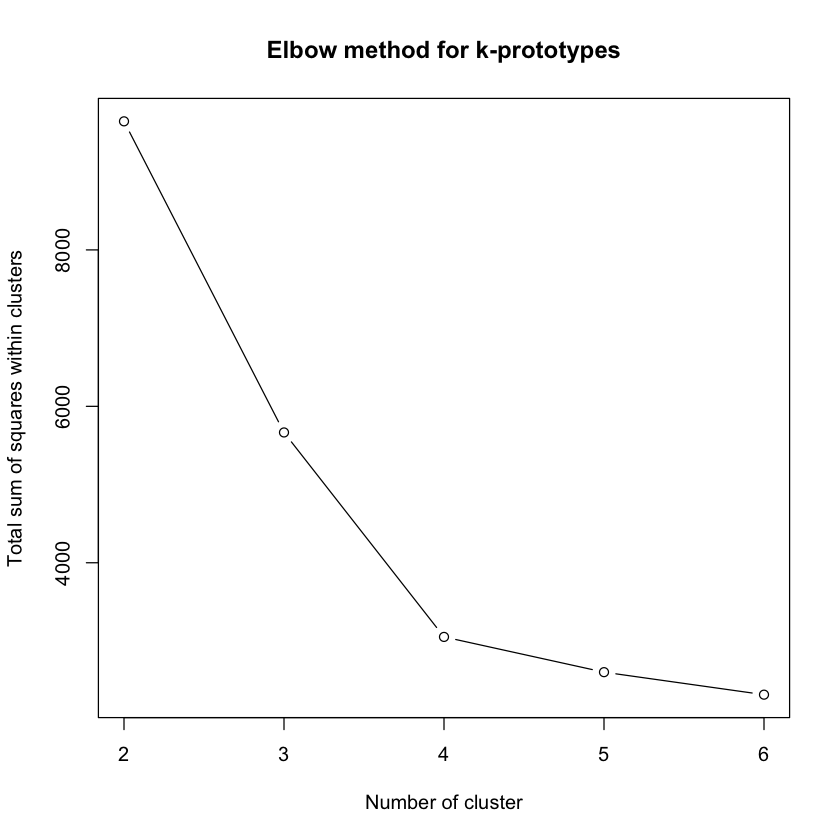

In [11]:
library(clustMixType)

df_oral <- df[, c("SEQN", "OHQ835", "OHQ845", "OHQ850", "OHQ855", 
                 "OHQ860", "OHQ865", "OHQ870", "OHQ875")]

for(var in c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")) {
  df_oral[[var]] <- as.factor(df_oral[[var]])
}

df_oral$OHQ845 <- factor(df_oral$OHQ845, 
                          levels = c(5, 4, 3, 2, 1),
                          ordered = TRUE)

df_oral$OHQ870 <- as.numeric(df_oral$OHQ870)
df_oral$OHQ875 <- as.numeric(df_oral$OHQ875)

cat_vars <- which(sapply(df_oral, is.factor))

set.seed(123)
k_values <- 2:6

kproto_results <- list()

for(k in k_values) {
  kproto_results[[as.character(k)]] <- kproto(df_oral[, -1], k = k, 
                                             lambda = rep(1, ncol(df_oral) - 1),
                                             nstart = 10)
}

wss <- sapply(kproto_results, function(x) x$tot.withinss)

par(bg = "white")
plot(k_values, wss, type = "b", 
     xlab = "Number of cluster", 
     ylab = "Total sum of squares within clusters",
     main = "Elbow method for k-prototypes")

In [12]:
k_best <- 4
best_model <- kproto_results[[as.character(k_best)]]

df_oral$cluster <- best_model$cluster

cluster_profiles <- aggregate(. ~ cluster, data = df_oral, 
                             FUN = function(x) {
                               if(is.factor(x)) {
                                 return(names(sort(table(x), decreasing = TRUE)[1]))
                               } else {
                                 return(mean(x, na.rm = TRUE))
                               }
                             })

print(cluster_profiles)

  cluster     SEQN   OHQ835   OHQ845   OHQ850   OHQ855   OHQ860   OHQ865
1       1 68353.31 1.845426 2.810726 1.785489 1.776025 1.867508 1.810726
2       2 66518.51 1.852941 3.257353 1.691176 1.852941 1.757353 1.852941
3       3 69258.77 1.825000 3.018750 1.643750 1.756250 1.756250 1.775000
4       4 68906.72 1.827907 2.725581 1.795349 1.711628 1.837209 1.841860
     OHQ870    OHQ875
1 0.6025237 0.5867508
2 6.4779412 0.5147059
3 6.5000000 6.6937500
4 0.4976744 6.5395349


In [ ]:
library(ggplot2)
library(Rtsne)
library(umap)

# Plot t-SNE

df_oral_numeric <- df_oral[, -1]
for (i in 1:(ncol(df_oral_numeric)-1)) {
  if (is.factor(df_oral_numeric[[i]])) {
    df_oral_numeric[[i]] <- as.numeric(df_oral_numeric[[i]])
  }
}

set.seed(123)
tsne_result <- Rtsne(df_oral_numeric[, 1:8], dims = 2, perplexity = 30, 
                     check_duplicates = FALSE)
tsne_data <- data.frame(
  X = tsne_result$Y[,1],
  Y = tsne_result$Y[,2],
  Cluster = factor(df_oral$cluster)
)

tsne_plot <- ggplot(tsne_data, aes(x = X, y = Y, color = Cluster)) +
  geom_point(alpha = 0.7) +
  theme_minimal() +
  labs(title = "View clusters with t-SNE",
       x = "t-SNE 1",
       y = "t-SNE 2")

tsne_plot

In [ ]:
# Radar Graph

library(fmsb)

cluster_centers <- aggregate(. ~ cluster, data = df_oral_numeric, mean)
radar_data <- cluster_centers[, -1]
rownames(radar_data) <- paste("Cluster", cluster_centers$cluster)

radar_data <- rbind(
  apply(radar_data, 2, max),  # Max for each column
  apply(radar_data, 2, min),  # Min for each column
  radar_data
)

colnames(radar_data) <- c("Gum disease", "Oral health", "Treatment", 
                          "Loose teeth", "Bone loss", "Abnormal tooth",
                          "Floss (days)", "Mouthwash (days)")

par(mar = c(1, 1, 2, 1))
par(bg = "white")
colors <- c("#FF5733", "#33FF57", "#3357FF", "#FF33E8")
radarchart(radar_data,
           pcol = colors,
           pfcol = scales::alpha(colors, 0.3),
           cglcol = "grey",
           cglty = 1,
           title = "Cluster Profiles")

legend("topright",
       legend = paste("Cluster", 1:4),
       col = colors,
       lty = 1,
       lwd = 2,
       pch = 19,
       bty = "n")

In [ ]:
# Direct display of the two most influential variables
    # OHQ870
    # OHQ875

ggplot(df_oral, aes(x = OHQ870, y = OHQ875, color = factor(cluster))) +
  geom_jitter(width = 0.2, height = 0.2, alpha = 0.7) +
  labs(title = "Cluster for use of dental floss and mouthwash",
       x = "Days I use dental floss (week)",
       y = "Days of use of mouthwash (week)",
       color = "Cluster") +
  theme_minimal()

#### Visualization using cluster from K-Prototypes results

In [5]:
library(dplyr)
library(tidyr)
library(knitr)
library(htmlTable)
library(ggplot2)
library(forcats)

In [6]:
# Function to handle calculations and format

format_num <- function(x, digits = 1) {
  return(format(round(x, digits), nsmall = digits))
}

med_iqr <- function(x) {
  med <- median(x, na.rm = TRUE)
  q1 <- quantile(x, 0.25, na.rm = TRUE)
  q3 <- quantile(x, 0.75, na.rm = TRUE)
  return(paste0(format_num(med), " [", format_num(q1), "-", format_num(q3), "]"))
}

n_perc <- function(x, total) {
  paste0(sum(x, na.rm = TRUE), " (", format_num(sum(x, na.rm = TRUE) / total * 100), "%)")
}

In [7]:
# Binary recoding function (1/2 -> 0/1): Converting to factors with 0=No, 1=Yes
recode_binary_factor <- function(x) {
  factor(ifelse(x == 1, 1, 0), levels = c(0, 1), labels = c("No", "Yes"))
}

# Recoding all features with consistent approach
df <- df %>%
  mutate(
    
    # Intrinsic capacity domains: binary recoding
    DLQ040_bin = recode_binary_factor(DLQ040),
    WHQ060_bin = recode_binary_factor(WHQ060),
    DLQ010_bin = recode_binary_factor(DLQ010),
    DLQ020_bin = recode_binary_factor(DLQ020),
    
    # Intrinsic capacity domains: convertion to binary factors
    PFQ061I_bin = factor(ifelse(PFQ061I == 1, 0, 1),
                     levels = c(0, 1), labels = c("No", "Yes")),
    DPQ050_bin = factor(ifelse(DPQ050 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
    DPQ020_bin = factor(ifelse(DPQ020 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
    DPQ010_bin = factor(ifelse(DPQ010 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
      
    # Demographic variables
    RIAGENDR = factor(RIAGENDR, levels = c(1, 2),
                    labels = c("Male", "Female")),
    
    DMDEDUC2 = factor(DMDEDUC2, levels = 1:5,
                     labels = c("Less than 9th grade", "9-11th grade",
                                "High school graduate",
                                "Some college/AA degree",
                                "College graduate or above"),
                     ordered = TRUE),
    
    RIDRETH1 = factor(RIDRETH1, levels = 1:5,
                      labels = c("Mexican American", "Other Hispanic",
                                "Non-Hispanic White", "Non-Hispanic Black",
                                "Other Race")),
    
    # Lifestyle variables - Set "No" as reference
    SMQ020 = factor(SMQ020, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Smoking status
    
    ALQ101 = factor(ALQ101, levels = c(2, 1),
                   labels = c("Under 12 drinks/1 yr", "Over 12 drinks/1 yr")),  # Alcohol
    
    # Medical conditions - all with "No" as reference level
    MCQ160B = factor(MCQ160B, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Heart failure
    
    MCQ160C = factor(MCQ160C, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Coronary heart disease
    
    MCQ160D = factor(MCQ160D, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Angina
    
    MCQ160E = factor(MCQ160E, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Heart attack
    
    MCQ160F = factor(MCQ160F, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Stroke
    
    MCQ220 = factor(MCQ220, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Cancer
    
    MCQ160L = factor(MCQ160L, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Liver condition
    
    BPQ020 = factor(BPQ020, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Hypertension
    
    # Multi-categorical - set "No" as reference
    DIQ010 = factor(DIQ010, levels = c(2, 1, 3),
                   labels = c("No", "Yes", "Borderline"))  # Diabetes
  )

# Verify transformations and check for any issues
summary(df[, c("DLQ040_bin", "WHQ060_bin", "DLQ010_bin", "DLQ020_bin",
               "PFQ061I_bin", "DPQ050_bin", "DPQ020_bin", "DPQ010_bin",
               "RIAGENDR", "DMDEDUC2", "RIDRETH1", "SMQ020", "ALQ101", 
               "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F", "MCQ220", "MCQ160L",
               "BPQ020", "DIQ010")])

 DLQ040_bin WHQ060_bin DLQ010_bin DLQ020_bin PFQ061I_bin DPQ050_bin DPQ020_bin
 No :759    No :344    No :699    No :678    No :588     No :615    No :600   
 Yes: 69    Yes:484    Yes:129    Yes:150    Yes:240     Yes:213    Yes:228   
                                                                              
                                                                              
                                                                              
 DPQ010_bin   RIAGENDR                        DMDEDUC2  
 No :600    Male  :417   Less than 9th grade      :106  
 Yes:228    Female:411   9-11th grade             :136  
                         High school graduate     :190  
                         Some college/AA degree   :235  
                         College graduate or above:161  
               RIDRETH1   SMQ020                     ALQ101    MCQ160B  
 Mexican American  : 85   No :396   Under 12 drinks/1 yr:276   No :746  
 Other Hispanic    : 64   Yes:432   Ov

In [8]:
covariates <- list(
  # Demographics
  demographic = c("RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDEDUC2", "INDFMPIR"),
  
  # General Health
  health = c("DIQ010", "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F", "MCQ160L", "MCQ220", "BPQ020"),
  
  # Other Covariates
  other = c("SMQ020", "ALQ101"),

  # Intrinsic Capacity
  ic = c('PFQ061I_bin','DPQ010_bin','DPQ020_bin','DPQ050_bin','DLQ040_bin','WHQ060_bin','DLQ010_bin', 'DLQ010_bin')
)

tables_list <- list()

In [13]:
# Add cluster column to df

df <- merge(df, df_oral[, c("SEQN", "cluster")], by = "SEQN", all.x = TRUE)
head(df[, c("SEQN", "cluster")])

,SEQN,cluster
,<int>,<int>
1,51633,3
2,51654,3
3,51680,2
4,51687,2
5,51736,3
6,51861,4


In [16]:
table(df$cluster)


  1   2   3   4 
317 136 160 215 

In [14]:
for(category_name in names(covariates)) {
  
  vars <- covariates[[category_name]]
  
  category_table <- data.frame(Covariate = character(),
                              Category = character(),
                              Cluster1 = character(),
                              Cluster2 = character(),
                              Cluster3 = character(),
                              Cluster4 = character(),
                              Total = character(),
                              stringsAsFactors = FALSE)
  
  for(var in vars) {
    
    if(!var %in% names(df)) {
      cat("Attention: Variable", var, "not found in the dataset\n")
      next
    }
    
    var_label <- var
    
    if(is.numeric(df[[var]])) {
      
      stats_by_cluster <- df %>%
        group_by(cluster) %>%
        summarise(value = med_iqr(!!sym(var)), .groups = "drop") %>%
        pivot_wider(names_from = cluster, values_from = value, names_prefix = "Cluster")
      
      total_stats <- med_iqr(df[[var]])
      
      row <- data.frame(
        Covariate = var_label,
        Category = "Continuous",
        stats_by_cluster,
        Total = total_stats,
        stringsAsFactors = FALSE
      )
      
      category_table <- bind_rows(category_table, row)
      
    } else {
      
      categories <- unique(df[[var]])
      categories <- categories[!is.na(categories)]
      
      for(cat in categories) {
        cat_by_cluster <- df %>%
          group_by(cluster) %>%
          summarise(
            value = n_perc(!!sym(var) == cat, n()), 
            .groups = "drop"
          ) %>%
          pivot_wider(names_from = cluster, values_from = value, names_prefix = "Cluster")
        
        total_cat <- n_perc(df[[var]] == cat, nrow(df))
        
        row <- data.frame(
          Covariate = var_label,
          Category = as.character(cat),
          cat_by_cluster,
          Total = total_cat,
          stringsAsFactors = FALSE
        )
        
        category_table <- bind_rows(category_table, row)
      }
      
      if(sum(is.na(df[[var]])) > 0) {
        na_by_cluster <- df %>%
          group_by(cluster) %>%
          summarise(
            value = n_perc(is.na(!!sym(var)), n()), 
            .groups = "drop"
          ) %>%
          pivot_wider(names_from = cluster, values_from = value, names_prefix = "Cluster")
        
        total_na <- n_perc(is.na(df[[var]]), nrow(df))
        
        row <- data.frame(
          Covariate = var_label,
          Category = "Missing",
          na_by_cluster,
          Total = total_na,
          stringsAsFactors = FALSE
        )
        
        category_table <- bind_rows(category_table, row)
      }
    }
  }
  
  tables_list[[category_name]] <- category_table
}

final_table <- bind_rows(tables_list)

kable(final_table, 
      caption = "Distribution of covariates by cluster",
      align = c('l', 'l', rep('c', 5)))



Table: Distribution of covariates by cluster

|Covariate   |Category                  |     Cluster1     |     Cluster2     |     Cluster3     |     Cluster4     |      Total       |
|:-----------|:-------------------------|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|
|RIDAGEYR    |Continuous                | 70.0 [63.0-77.0] | 68.0 [62.0-74.0] | 68.0 [63.0-74.0] | 69.0 [63.0-75.0] | 69.0 [63.0-75.0] |
|RIAGENDR    |Male                      |   175 (55.2%)    |    53 (39.0%)    |    80 (50.0%)    |   109 (50.7%)    |   417 (50.4%)    |
|RIAGENDR    |Female                    |   142 (44.8%)    |    83 (61.0%)    |    80 (50.0%)    |   106 (49.3%)    |   411 (49.6%)    |
|RIDRETH1    |Non-Hispanic White        |   166 (52.4%)    |    81 (59.6%)    |    69 (43.1%)    |    82 (38.1%)    |   398 (48.1%)    |
|RIDRETH1    |Non-Hispanic Black        |    75 (23.7%)    |    23 (16.9%)    |    52 (32.5%)    |    92 (42.8%)    |   242 (29.2%

In [15]:
library(htmlTable)
view_html <- htmlTable::htmlTable(
  final_table,
  caption = "Complete table of covariates by cluster",
  css.cell = "padding: 5px;",
  css.class = "table table-striped table-bordered",
  rnames = FALSE,
  align = c('l', 'l', rep('c', 5)),
  col.rgroup = c("none", "#F7F7F7"),
  tfoot = paste0("Note: For continuous variables, the values are expressed as 'Median [Q1-Q3]'.",
                "For categorical variables, values are expressed as 'n (%)'."),
  n.tspanner = sapply(tables_list, nrow),
  tspanner = names(tables_list)
)

html_file <- tempfile(fileext = ".html")
writeLines(view_html, html_file)
browseURL(html_file)

In [ ]:
# Statistic tests

run_tests <- function(df, vars) {
  test_results <- data.frame(
    Variable = character(),
    Test = character(),
    P_Value = numeric(),
    Significance = character(),
    stringsAsFactors = FALSE
  )
  
  for(var in vars) {
    if(!var %in% names(df)) next
    
    if(is.numeric(df[[var]])) {
      test <- try(summary(aov(as.formula(paste(var, "~ cluster")), data = df)), silent = TRUE)
      if(!inherits(test, "try-error")) {
        p_value <- test[[1]][["Pr(>F)"]][1]
        
        test_results <- bind_rows(test_results, data.frame(
          Variable = var,
          Test = "ANOVA",
          P_Value = p_value,
          Significance = ifelse(p_value < 0.05, "*", ""),
          stringsAsFactors = FALSE
        ))
      }
      
    } else {
      test <- try(chisq.test(table(df[[var]], df$cluster)), silent = TRUE)
      if(!inherits(test, "try-error")) {
        p_value <- test$p.value
        
        test_results <- bind_rows(test_results, data.frame(
          Variable = var,
          Test = "Chi-square",
          P_Value = p_value,
          Significance = ifelse(p_value < 0.05, "*", ""),
          stringsAsFactors = FALSE
        ))
      }
    }
  }
  
  return(test_results)
}

all_vars <- unlist(covariates)

test_results <- run_tests(df, all_vars)

kable(test_results,
      caption = "Results of statistical tests",
      col.names = c("Variable", "Test", "P-value", "Significance (p<0.05)"),
      digits = 3)

significant_vars <- test_results$Variable[test_results$P_Value < 0.05]

create_plots <- function(df, significant_vars) {
  plots <- list()
  
  for(var in significant_vars) {
    if(!var %in% names(df)) next
    
    var_label <- var
    
    if(is.numeric(df[[var]])) {
      p <- ggplot(df, aes(x = factor(cluster), y = !!sym(var), fill = factor(cluster))) +
        geom_boxplot() +
        labs(title = paste("Distribution of", var_label, "for cluster"),
             x = "Cluster",
             y = var_label) +
        theme_minimal() +
        theme(legend.position = "none")
      
      plots[[var]] <- p
    } else {
      p <- df %>%
        group_by(cluster, !!sym(var)) %>%
        summarise(count = n(), .groups = "drop") %>%
        group_by(cluster) %>%
        mutate(percentage = count / sum(count) * 100) %>%
        ggplot(aes(x = factor(cluster), y = percentage, fill = factor(!!sym(var)))) +
        geom_bar(stat = "identity", position = "fill") +
        labs(title = paste("Distribution of", var_label, "for cluster"),
             x = "Cluster",
             y = "Percentage",
             fill = var_label) +
        theme_minimal() +
        scale_y_continuous(labels = scales::percent_format(scale = 1))
      
      plots[[var]] <- p
    }
  }
  
  return(plots)
}

plots <- create_plots(df, significant_vars)

In [ ]:
library(gridExtra)
options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(grobs = plots, ncol = 2)

### Descriptive Analysis

#### Merging datasets
> using only 3 features from general oral health

In [8]:
# Merge datasets demographics and intrinsic capacity data

datasets_09_10 <- list(
  demo_09_10_selected, alcohol_09_10_selected, smoking_09_10_selected, med_conditions_09_10_selected,
  blood_pressure_09_10_selected, diabetes_09_10_selected,
  locomotion_09_10_selected, mental_health_09_10_selected,
  weight_history_09_10_selected, audiometry_09_10_selected, oral_09_10_selected
)

datasets_11_12 <- list(
  demo_11_12_selected, alcohol_11_12_selected, smoking_11_12_selected, med_conditions_11_12_selected,
  blood_pressure_11_12_selected, diabetes_11_12_selected,
  locomotion_11_12_selected, mental_health_11_12_selected,
  weight_history_11_12_selected, audiometry_11_12_selected, oral_11_12_selected
)

datasets_13_14 <- list(
  demo_13_14_selected, alcohol_13_14_selected, smoking_13_14_selected, med_conditions_13_14_selected,
  blood_pressure_13_14_selected, diabetes_13_14_selected,
  locomotion_13_14_selected, disability_13_14_selected, mental_health_13_14_selected,
  weight_history_13_14_selected, oral_13_14_selected
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

df_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_09_10)

df_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_11_12)

df_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_13_14)

# Vertical union

df_final <- bind_rows(df_09_10, df_11_12, df_13_14)

print("Dimensions before removing NA values")
dim(df_final)

df_final = subset(df_final, select = -c(OHQ835,OHQ845, OHQ855, OHQ860, OHQ865))
print('Dimensions with only 3 oral health features before removing NA values')
dim(df_final)

# Filter with AGE >= 60

df_final_age_60 <- subset(df_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(df_final_age_60)

# Excluding patients with missing values in Intrinsic Capacity features

df_final_excluding_IC <- df_final_age_60[complete.cases(df_final_age_60[, c('DLQ020', 'PFQ061I', 'DPQ010', 'DPQ020', 'DPQ050', 'DLQ040', 'WHQ060', 'DLQ010')]), ]

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 9))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 7))

df_final_excluding_IC <- df_final_excluding_IC %>%
  filter(!if_any(c(DLQ020, PFQ061I, DLQ040, WHQ060, DLQ010,
                   DPQ020, DPQ050, DPQ010), ~ . == 99))

print("Dimensions without IC missing values")
dim(df_final_excluding_IC)

# Excluding patients with no examinations for Oral examination

df_final_excluding_oral <- df_final_excluding_IC[complete.cases(
  df_final_excluding_IC[, c(
                            "OHQ850",
                            "OHQ870",
                            "OHQ875"
                          )]), ]

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ850, OHQ870, OHQ875), ~ . == 9))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ850), ~ . == 7))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ870, OHQ875), ~ . == 77))

df_final_excluding_oral <- df_final_excluding_oral %>%
  filter(!if_any(c(OHQ870, OHQ875), ~ . == 99))

print("Dimensions without complete Oral examination (missing values)")
dim(df_final_excluding_oral)

# Excluding patients with missing values in Confounding features

df_final_excluding_confounding <- df_final_excluding_oral[complete.cases(df_final_excluding_oral[, 
                                  c('RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2', 'INDFMPIR', 'ALQ101', 'SMQ020', 'MCQ160B',
                                  'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160L', 'MCQ220', 'BPQ020', 'DIQ010')]), ]

df_final_merged <- df_final_excluding_confounding %>%
  filter(!if_any(c(DMDEDUC2, ALQ101, MCQ160B, MCQ160C, MCQ160D,
                   MCQ160E, MCQ160F, MCQ160L, BPQ020, DIQ010), ~ . == 9))

print("Dimensions without Confounding missing values")
dim(df_final_merged)

[1] "Dimensions before removing NA values"


[1] 30468    33

[1] "Dimensions with only 3 oral health features before removing NA values"


[1] 30468    28

[1] "Dimensions with AGE >= 60"


[1] 5705   28

[1] "Dimensions without IC missing values"


[1] 994  28

[1] "Dimensions without complete Oral examination (missing values)"


[1] 945  28

[1] "Dimensions without Confounding missing values"


[1] 845  28

In [9]:
# Saving preprocessed

write.csv(df_final_merged, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14_3_features.csv", row.names=FALSE)

#### Loading DF & Weights

In [10]:
three_features = TRUE

if (three_features == TRUE) {
   df_path = "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14_3_features.csv"
} else {
   df_path = "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/df_oral_health_09_14.csv"
}

df <- read.csv(df_path, 
              stringsAsFactors = TRUE)

head(df)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,PFQ061I,DPQ010,DPQ020,DPQ050,DLQ040,WHQ060,DLQ010,OHQ850,OHQ870,OHQ875
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,51633,1,80,3,4,1.27,1,1,1,2,...,1,0,0,0,2,1,2,2,5,6
2,51654,1,66,3,4,2.20,1,1,2,2,...,1,0,0,0,2,2,2,1,7,7
3,51680,2,60,4,4,2.59,1,1,1,2,...,1,0,1,1,2,1,2,2,7,0
4,51687,1,78,3,5,5.00,1,1,2,2,...,1,0,0,0,2,2,2,2,7,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,1,0,1,0,2,1,2,2,4,6
6,51861,1,80,3,3,4.94,1,2,2,2,...,2,0,0,0,2,1,1,2,0,7


In [6]:
# Select weights

# Weights from Demographic datasets

demo_09_10 <- read_xpt(file.path(path_to_data_09_10, "DEMO_F.xpt"))

demo_09_10_weights <- demo_09_10 %>%
    select(SEQN, RIDAGEYR, WTMEC2YR, SDMVPSU, SDMVSTRA)

demo_11_12 <- read_xpt(file.path(path_to_data_11_12, "DEMO_G.xpt.txt"))

demo_11_12_weights <- demo_11_12 %>%
    select(SEQN, RIDAGEYR, WTMEC2YR, SDMVPSU, SDMVSTRA)

demo_13_14 <- read_xpt(file.path(path_to_data_13_14, "DEMO_H.xpt.txt"))

demo_13_14_weights <- demo_13_14 %>%
    select(SEQN, RIDAGEYR, WTMEC2YR, SDMVPSU, SDMVSTRA)

weights_09_10 <- list(
  demo_09_10_weights
)

weights_11_12 <- list(
  demo_11_12_weights
)

weights_13_14 <- list(
  demo_13_14_weights
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

wt_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), weights_09_10)

wt_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), weights_11_12)

wt_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), weights_13_14)

# Vertical union

wt_final <- bind_rows(wt_09_10, wt_11_12, wt_13_14)

print("Dimensions before removing NA values")
dim(wt_final)

# Filter with AGE >= 60

wt_final_age_60 <- subset(wt_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(wt_final_age_60)

wt_final_age_60 <- subset(wt_final_age_60, select = -RIDAGEYR)
head(wt_final_age_60)

# Merge wt_final_age_60 with my final data frame

df_final_merged <- df %>%
  inner_join(wt_final_age_60, by = "SEQN")

dim(df_final_merged)

[1] "Dimensions before removing NA values"


[1] 30468     5

[1] "Dimensions with AGE >= 60"


[1] 5705    5

SEQN,WTMEC2YR,SDMVPSU,SDMVSTRA
<dbl>,<dbl>,<dbl>,<dbl>
51628,21000.339,2,75
51633,12381.115,1,77
51635,22502.507,1,79
51645,9590.458,1,75
51654,55670.350,2,86
51661,6385.327,2,88


[1] 828  36

In [7]:
# Preprocessing for WTMEC2YR: divide it for the number of NHANES cycles used (3 for our case)

df_final_merged[, "wt"] = df_final_merged[, "WTMEC2YR"] / 3

head(df_final_merged)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,OHQ850,OHQ855,OHQ860,OHQ865,OHQ870,OHQ875,WTMEC2YR,SDMVPSU,SDMVSTRA,wt
,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,51633,1,80,3,4,1.27,1,1,1,2,...,2,2,2,2,5,6,12381.115,1,77,4127.038
2,51654,1,66,3,4,2.20,1,1,2,2,...,1,2,1,2,7,7,55670.350,2,86,18556.783
3,51680,2,60,4,4,2.59,1,1,1,2,...,2,2,1,1,7,0,18341.270,1,79,6113.757
4,51687,1,78,3,5,5.00,1,1,2,2,...,2,2,2,2,7,0,42248.559,2,82,14082.853
5,51736,2,60,1,3,0.68,1,1,2,2,...,2,2,2,2,4,6,7084.377,1,81,2361.459
6,51861,1,80,3,3,4.94,1,2,2,2,...,2,1,2,2,0,7,22127.661,1,76,7375.887


In [8]:
# Save df with weights

write.csv(df_final_merged, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/preprocessed_df_oral_health_09_14_with_weights.csv", row.names=FALSE)

In [9]:
# Using srvyr to check population estimate
library(srvyr)

svy_obj <- df_final_merged %>%
  as_survey_design(
    ids = SDMVPSU,
    strata = SDMVSTRA,
    weights = wt,
    nest = TRUE
  )

pop_est <- svy_obj %>%
  summarize(pop = survey_total(1, vartype = "ci"))

print(pop_est)


Attaching package: 'srvyr'


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:stats':

    filter




# A tibble: 1 x 3
       pop  pop_low   pop_upp
     <dbl>    <dbl>     <dbl>
1 8947870. 7745368. 10150373.


#### Binarization

In [ ]:
# First approach: Binarization of variables

df_binary <- df %>%
  mutate(
    # (1=Yes, 2=No)
    OHQ835_bin = ifelse(OHQ835 == 1, 1, 0),
    OHQ850_bin = ifelse(OHQ850 == 1, 1, 0),
    OHQ855_bin = ifelse(OHQ855 == 1, 1, 0),
    OHQ860_bin = ifelse(OHQ860 == 1, 1, 0),
    OHQ865_bin = ifelse(OHQ865 == 1, 1, 0),
    
    # Ordinal variable (1-5, where 1 is "Excellent")
    OHQ845_bin = ifelse(OHQ845 >= 4, 0, 1),
    
    # Continous variables (0-7 days)
    OHQ870_bin = ifelse(OHQ870 >= 4, 1, 0),  # ≥4 days a week = regular usage
    OHQ875_bin = ifelse(OHQ875 >= 4, 1, 0)   # ≥4 days a week = regular usage
  )

binary_vars <- c("OHQ835_bin", "OHQ845_bin", "OHQ850_bin", "OHQ855_bin",
                 "OHQ860_bin", "OHQ865_bin", "OHQ870_bin", "OHQ875_bin")
#df_binary[binary_vars] <- lapply(df_binary[binary_vars], function(x) factor(x, levels = c(0, 1), labels = c("0", "1")))

head(df_binary)
describe(df_binary[binary_vars])

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,OHQ870,OHQ875,OHQ835_bin,OHQ850_bin,OHQ855_bin,OHQ860_bin,OHQ865_bin,OHQ845_bin,OHQ870_bin,OHQ875_bin
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,51633,1,80,3,4,1.27,1,1,1,2,...,5,6,0,0,0,0,0,1,1,1
2,51654,1,66,3,4,2.20,1,1,2,2,...,7,7,0,1,0,1,0,1,1,1
3,51680,2,60,4,4,2.59,1,1,1,2,...,7,0,0,0,0,1,1,1,1,0
4,51687,1,78,3,5,5.00,1,1,2,2,...,7,0,0,0,0,0,0,1,1,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,4,6,0,0,0,0,0,1,1,1
6,51861,1,80,3,3,4.94,1,2,2,2,...,0,7,0,0,1,0,0,1,0,1


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OHQ835_bin,1,828,0.1618357,0.3685227,0,0.07831325,0,0,1,1,1.8330261,1.3616336,0.01280705
OHQ845_bin,2,828,0.6425121,0.4795498,1,0.67771084,0,0,1,1,-0.5936399,-1.6495795,0.01666551
OHQ850_bin,3,828,0.2548309,0.4360295,0,0.19427711,0,0,1,1,1.1231945,-0.7393226,0.01515307
OHQ855_bin,4,828,0.2318841,0.4222904,0,0.16566265,0,0,1,1,1.2682841,-0.3919243,0.01467561
OHQ860_bin,5,828,0.1799517,0.3843794,0,0.10090361,0,0,1,1,1.6632618,0.7673709,0.01335811
OHQ865_bin,6,828,0.1811594,0.3853830,0,0.10240964,0,0,1,1,1.6526702,0.7322076,0.01339299
OHQ870_bin,7,828,0.3574879,0.4795498,0,0.32228916,0,0,1,1,0.5936399,-1.6495795,0.01666551
OHQ875_bin,8,828,0.4528986,0.4980774,0,0.44126506,0,0,1,1,0.1889046,-1.9666859,0.01730939


In [5]:
table(df_binary$OHQ870_bin)


  0   1 
532 296 

In [6]:
table(df_binary$OHQ870)


  0   1   2   3   4   5   6   7 
391  36  53  52  33  23   6 234 

In [12]:
sum(table(df_binary$OHQ870[df_binary$OHQ870!= 0]))

[1] 437

In [20]:
391/sum(table(df_binary$OHQ870)) *100
437/sum(table(df_binary$OHQ870)) *100

[1] 47.22222

[1] 52.77778

In [17]:
table(df_binary$OHQ875_bin)


  0   1 
453 375 

In [15]:
table(df_binary$OHQ875)


  0   1   2   3   4   5   6   7 
336  27  41  49  35  16  11 313 

In [16]:
sum(table(df_binary$OHQ875[df_binary$OHQ875!= 0]))

[1] 492

In [19]:
336/sum(table(df_binary$OHQ875)) *100
492/sum(table(df_binary$OHQ875)) *100

[1] 40.57971

[1] 59.42029

#### Unique Binary Variable
> general_oral_index = sum(indices)

- general_oral_index between 0 and 2 --> "bad" oral health
- general_oral_index between 3 and 4 --> "intermediate" oral health
- general_oral_index between 5 and 8 --> "excellent" oral health

In [16]:
# First approach: Binarization of variables and Unique Variable

df_binary <- df %>%
  mutate(
    # (1=Yes, 2=No)
    OHQ835_bin = ifelse(OHQ835 == 1, 1, 0),
    OHQ850_bin = ifelse(OHQ850 == 1, 1, 0),
    OHQ855_bin = ifelse(OHQ855 == 1, 1, 0),
    OHQ860_bin = ifelse(OHQ860 == 1, 1, 0),
    OHQ865_bin = ifelse(OHQ865 == 1, 1, 0),
    
    # Ordinal variable (1-5, where 1 is "Excellent")
    OHQ845_bin = ifelse(OHQ845 >= 4, 0, 1),
    
    # Continous variables (0-7 days)
    OHQ870_bin = ifelse(OHQ870 >= 3, 1, 0),  # ≥3 days a week = regular usage
    OHQ875_bin = ifelse(OHQ875 >= 3, 1, 0),   # ≥3 days a week = regular usage
  )

binary_vars <- c("OHQ835_bin", "OHQ845_bin", "OHQ850_bin", "OHQ855_bin",
                 "OHQ860_bin", "OHQ865_bin", "OHQ870_bin", "OHQ875_bin")
df_binary <- df_binary %>%
  mutate(
    # unique general oral index
    total_score = rowSums(df_binary[binary_vars]),
    
    general_oral_index = case_when(
      total_score >= 0 & total_score <= 2 ~ "bad",           # between 0 and 2
      total_score >= 3 & total_score <= 4 ~ "intermediate",  # between 3 and 4
      total_score >= 5 & total_score <= 8 ~ "excellent"      # between 5 and 7
    ),

    general_oral_index = factor(general_oral_index, 
                                levels = c("bad", "intermediate", "excellent"), 
                                labels = c(0, 1, 2))
  )
#df_binary[binary_vars] <- lapply(df_binary[binary_vars], function(x) factor(x, levels = c(0, 1), labels = c("0", "1")))

head(df_binary)
describe(df_binary[binary_vars])
print(table(df_binary$general_oral_index))

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,OHQ835_bin,OHQ850_bin,OHQ855_bin,OHQ860_bin,OHQ865_bin,OHQ845_bin,OHQ870_bin,OHQ875_bin,total_score,general_oral_index
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,51633,1,80,3,4,1.27,1,1,1,2,...,0,0,0,0,0,1,1,1,3,1
2,51654,1,66,3,4,2.20,1,1,2,2,...,0,1,0,1,0,1,1,1,5,2
3,51680,2,60,4,4,2.59,1,1,1,2,...,0,0,0,1,1,1,1,0,4,1
4,51687,1,78,3,5,5.00,1,1,2,2,...,0,0,0,0,0,1,1,0,2,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,0,0,0,0,0,1,1,1,3,1
6,51861,1,80,3,3,4.94,1,2,2,2,...,0,0,1,0,0,1,0,1,3,1


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OHQ835_bin,1,828,0.1618357,0.3685227,0,0.07831325,0,0,1,1,1.83302611,1.3616336,0.01280705
OHQ845_bin,2,828,0.6425121,0.4795498,1,0.67771084,0,0,1,1,-0.59363991,-1.6495795,0.01666551
OHQ850_bin,3,828,0.2548309,0.4360295,0,0.19427711,0,0,1,1,1.12319454,-0.7393226,0.01515307
OHQ855_bin,4,828,0.2318841,0.4222904,0,0.16566265,0,0,1,1,1.26828413,-0.3919243,0.01467561
OHQ860_bin,5,828,0.1799517,0.3843794,0,0.10090361,0,0,1,1,1.66326178,0.7673709,0.01335811
OHQ865_bin,6,828,0.1811594,0.3853830,0,0.10240964,0,0,1,1,1.65267023,0.7322076,0.01339299
OHQ870_bin,7,828,0.4202899,0.4939037,0,0.40060241,0,0,1,1,0.32238620,-1.8983555,0.01716434
OHQ875_bin,8,828,0.5120773,0.5001562,1,0.51506024,0,0,1,1,-0.04823576,-2.0000845,0.01738163



  0   1   2 
438 300  90 


#### 8 Descriptive Analysis for each general oral health feature (no mod)

In [ ]:
# Pre-processing - TO BE FIXED

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df[binary_vars] <- lapply(df[binary_vars], as.factor)

df$OHQ845 <- factor(df$OHQ845, 
                         levels = c(1,2,3,4,5),
                         ordered = TRUE)

head(df)

In [ ]:
# Binary recoding function (1/2 -> 0/1): Converting to factors with 0=No, 1=Yes
recode_binary_factor <- function(x) {
  factor(ifelse(x == 1, 1, 0), levels = c(0, 1), labels = c("No", "Yes"))
}

# Recoding all features with consistent approach
df <- df %>%
  mutate(
    
    # Intrinsic capacity domains: binary recoding
    DLQ040_bin = recode_binary_factor(DLQ040),
    WHQ060_bin = recode_binary_factor(WHQ060),
    DLQ010_bin = recode_binary_factor(DLQ010),
    DLQ020_bin = recode_binary_factor(DLQ020),
    
    # Intrinsic capacity domains: convertion to binary factors
    PFQ061I_bin = factor(ifelse(PFQ061I == 1, 0, 1),
                     levels = c(0, 1), labels = c("No", "Yes")),
    DPQ050_bin = factor(ifelse(DPQ050 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
    DPQ020_bin = factor(ifelse(DPQ020 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
    DPQ010_bin = factor(ifelse(DPQ010 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
      
    # Demographic variables
    RIAGENDR = factor(RIAGENDR, levels = c(1, 2),
                    labels = c("Male", "Female")),
    
    DMDEDUC2 = factor(DMDEDUC2, levels = 1:5,
                     labels = c("Less than 9th grade", "9-11th grade",
                                "High school graduate",
                                "Some college/AA degree",
                                "College graduate or above"),
                     ordered = TRUE),
    
    RIDRETH1 = factor(RIDRETH1, levels = 1:5,
                      labels = c("Mexican American", "Other Hispanic",
                                "Non-Hispanic White", "Non-Hispanic Black",
                                "Other Race")),
    
    # Lifestyle variables - Set "No" as reference
    SMQ020 = factor(SMQ020, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Smoking status
    
    ALQ101 = factor(ALQ101, levels = c(2, 1),
                   labels = c("Under 12 drinks/1 yr", "Over 12 drinks/1 yr")),  # Alcohol
    
    # Medical conditions - all with "No" as reference level
    MCQ160B = factor(MCQ160B, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Heart failure
    
    MCQ160C = factor(MCQ160C, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Coronary heart disease
    
    MCQ160D = factor(MCQ160D, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Angina
    
    MCQ160E = factor(MCQ160E, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Heart attack
    
    MCQ160F = factor(MCQ160F, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Stroke
    
    MCQ220 = factor(MCQ220, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Cancer
    
    MCQ160L = factor(MCQ160L, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Liver condition
    
    BPQ020 = factor(BPQ020, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Hypertension
    
    # Multi-categorical - set "No" as reference
    DIQ010 = factor(DIQ010, levels = c(2, 1, 3),
                   labels = c("No", "Yes", "Borderline"))  # Diabetes
  )

# Verify transformations and check for any issues
summary(df[, c("DLQ040_bin", "WHQ060_bin", "DLQ010_bin", "DLQ020_bin",
               "PFQ061I_bin", "DPQ050_bin", "DPQ020_bin", "DPQ010_bin",
               "RIAGENDR", "DMDEDUC2", "RIDRETH1", "SMQ020", "ALQ101", 
               "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F", "MCQ220", "MCQ160L",
               "BPQ020", "DIQ010")])

#### Only Overall Descriptive Analysis

In [ ]:
# Pre-processing - TO BE FIXED

oral_vars <- c("OHQ835", "OHQ845", "OHQ850", "OHQ855", 
               "OHQ860", "OHQ865", "OHQ870", "OHQ875")

binary_vars <- c("OHQ835", "OHQ850", "OHQ855", "OHQ860", "OHQ865")
df[binary_vars] <- lapply(df[binary_vars], as.factor)

df$OHQ845 <- factor(df$OHQ845, 
                    levels = c(1, 2, 3, 4, 5),
                    ordered = TRUE)

head(df)

In [10]:
# Binary recoding function (1/2 -> 0/1): Converting to factors with 0=No, 1=Yes
recode_binary_factor <- function(x) {
  factor(ifelse(x == 1, 1, 0), levels = c(0, 1), labels = c("No", "Yes"))
}

# Recoding all features with consistent approach
df_final_merged <- df_final_merged %>%
  mutate(
    
    # Intrinsic capacity domains: binary recoding
    DLQ040_bin = recode_binary_factor(DLQ040),
    WHQ060_bin = recode_binary_factor(WHQ060),
    DLQ010_bin = recode_binary_factor(DLQ010),
    DLQ020_bin = recode_binary_factor(DLQ020),
    
    # Intrinsic capacity domains: convertion to binary factors
    PFQ061I_bin = factor(ifelse(PFQ061I == 1, 0, 1),
                     levels = c(0, 1), labels = c("No", "Yes")),
    DPQ050_bin = factor(ifelse(DPQ050 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
    DPQ020_bin = factor(ifelse(DPQ020 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
    DPQ010_bin = factor(ifelse(DPQ010 == 0, 0, 1),
                    levels = c(0, 1), labels = c("No", "Yes")),
      
    # Demographic variables
    RIAGENDR = factor(RIAGENDR, levels = c(1, 2),
                    labels = c("Male", "Female")),
    
    DMDEDUC2 = factor(DMDEDUC2, levels = 1:5,
                     labels = c("Less than 9th grade", "9-11th grade",
                                "High school graduate",
                                "Some college/AA degree",
                                "College graduate or above"),
                     ordered = TRUE),
    
    RIDRETH1 = factor(RIDRETH1, levels = 1:5,
                      labels = c("Mexican American", "Other Hispanic",
                                "Non-Hispanic White", "Non-Hispanic Black",
                                "Other Race")),
    
    # Lifestyle variables - Set "No" as reference
    SMQ020 = factor(SMQ020, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Smoking status
    
    ALQ101 = factor(ALQ101, levels = c(2, 1),
                   labels = c("Under 12 drinks/1 yr", "Over 12 drinks/1 yr")),  # Alcohol
    
    # Medical conditions - all with "No" as reference level
    MCQ160B = factor(MCQ160B, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Heart failure
    
    MCQ160C = factor(MCQ160C, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Coronary heart disease
    
    MCQ160D = factor(MCQ160D, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Angina
    
    MCQ160E = factor(MCQ160E, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Heart attack
    
    MCQ160F = factor(MCQ160F, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Stroke
    
    MCQ220 = factor(MCQ220, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Cancer
    
    MCQ160L = factor(MCQ160L, levels = c(2, 1),
                    labels = c("No", "Yes")),  # Liver condition
    
    BPQ020 = factor(BPQ020, levels = c(2, 1),
                   labels = c("No", "Yes")),  # Hypertension
    
    # Multi-categorical - set "No" as reference
    DIQ010 = factor(DIQ010, levels = c(2, 1, 3),
                   labels = c("No", "Yes", "Borderline"))  # Diabetes
  )

# Verify transformations and check for any issues
summary(df_final_merged[, c("DLQ040_bin", "WHQ060_bin", "DLQ010_bin", "DLQ020_bin",
               "PFQ061I_bin", "DPQ050_bin", "DPQ020_bin", "DPQ010_bin",
               "RIAGENDR", "DMDEDUC2", "RIDRETH1", "SMQ020", "ALQ101", 
               "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F", "MCQ220", "MCQ160L",
               "BPQ020", "DIQ010")])

 DLQ040_bin WHQ060_bin DLQ010_bin DLQ020_bin PFQ061I_bin DPQ050_bin DPQ020_bin
 No :759    No :344    No :699    No :678    No :588     No :615    No :600   
 Yes: 69    Yes:484    Yes:129    Yes:150    Yes:240     Yes:213    Yes:228   
                                                                              
                                                                              
                                                                              
 DPQ010_bin   RIAGENDR                        DMDEDUC2  
 No :600    Male  :417   Less than 9th grade      :106  
 Yes:228    Female:411   9-11th grade             :136  
                         High school graduate     :190  
                         Some college/AA degree   :235  
                         College graduate or above:161  
               RIDRETH1   SMQ020                     ALQ101    MCQ160B  
 Mexican American  : 85   No :396   Under 12 drinks/1 yr:276   No :746  
 Other Hispanic    : 64   Yes:432   Ov

In [14]:
# Create survey design for NHANES datasets

nhanes_design <- svydesign(
  id = ~SDMVPSU,
  strata = ~SDMVSTRA,
  weights = ~wt,
  nest = TRUE,
  data = df_final_merged
)

In [26]:
# Descriptive analysis

create_descriptive_table <- function(df, survey_design = NULL) {
  require(gtsummary)
  require(dplyr)
  require(survey)
  require(srvyr)
  
  # Check if survey design is provided
  use_survey_design <- !is.null(survey_design)
  
  # Normality test a priori for continuous variables
  continuous_vars <- c("RIDAGEYR", "INDFMPIR")
  
  normality_results <- list()
  
  for (var in continuous_vars) {
    # Limit: 5000 observations for Shapiro-Wilk test
    if (length(na.omit(df[[var]])) > 5000) {
      sample_data <- sample(na.omit(df[[var]]), 5000)
    } else {
      sample_data <- na.omit(df[[var]])
    }
    
    test_result <- shapiro.test(sample_data)
    normality_results[[var]] <- test_result$p.value > 0.05
    message(var, " p-value: ", test_result$p.value)
  }
  
  message("Normality test results:")
  for (var in names(normality_results)) {
    message(var, ": ", ifelse(normality_results[[var]], "Normal", "Non-normal"))
  }

  variables_to_include <- c("RIDAGEYR", "INDFMPIR", "RIAGENDR",
                "DMDEDUC2", "RIDRETH1", "SMQ020", "ALQ101",
                "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F", "MCQ220", "MCQ160L",
                "BPQ020", "DIQ010", "DLQ040_bin", "WHQ060_bin", "DLQ010_bin", "DLQ020_bin",
                "PFQ061I_bin", "DPQ050_bin", "DPQ020_bin", "DPQ010_bin")
  
  # Variables using median (IQR) or mean (SD)
  median_vars <- names(normality_results)[!unlist(normality_results)]

  stat_labels <- list(
    "RIDAGEYR" = "Age (mean, SD)",
    "INDFMPIR" = "Ratio of family income (mean, SD)",
    "RIAGENDR" = "Gender (n, %)",
    "RIDRETH1" = "Ethnicity (n, %)",
    "DMDEDUC2" = "Education (n, %)",
    "SMQ020" = "Smoking (n, %)",
    "ALQ101" = "Alcohol intake (n, %)",
    "MCQ160B" = "Heart Failure (n, %)",
    "MCQ160C" = "Coronary Heart (n, %)",
    "MCQ160D" = "Angina (n, %)",
    "MCQ160E" = "Heart Attack (n, %)",
    "MCQ160F" = "Stroke (n, %)",
    "MCQ220" = "Cancer (n, %)",
    "MCQ160L" = "Liver (n, %)",
    "BPQ020" = "Hypertension (n, %)",
    "DIQ010" = "Diabetes (n, %)",
    "DLQ040_bin" = "Cognition (n, %)",
    "WHQ060_bin" = "Weight loss (n, %)",
    "DLQ010_bin" = "Difficulty Hearing (n, %)",
    "DLQ020_bin" = "Difficulty Seeing (n, %)",
    "PFQ061I_bin" = "Locomotion (n, %)",
    "DPQ050_bin" = "Nutrition (n, %)",
    "DPQ020_bin" = "Mood (n, %)",
    "DPQ010_bin" = "Anhedonia (n, %)"
  )
  
  for (var in names(normality_results)) {
    if (normality_results[[var]]) {
      stat_labels[[var]] <- gsub("\\(median, IQR\\)", "(mean, SD)", stat_labels[[var]])
    } else {
      stat_labels[[var]] <- gsub("\\(mean, SD\\)", "(median, IQR)", stat_labels[[var]])
    }
  }

  # Define statistics
  stat_list <- list(
    all_continuous() ~ "{mean} ({sd})",
    all_categorical() ~ "{n} ({p}%)"
  )
  for (var in median_vars) {
    stat_list[[var]] <- "{median} ({p25}, {p75})"
  }

  table_strat <- df %>%
      tbl_summary(
        include = all_of(variables_to_include),
        statistic = stat_list,
        label = stat_labels,
        missing = "ifany",
        missing_text = "Missing",
        digits = all_continuous() ~ 2,
        value = all_categorical() ~ "level",
        type = all_categorical() ~ "categorical"
      )
  
  # Calculate N for each group
  total_n <- nrow(df)
  
  # Add weighted N in millions column only if survey design is provided
  if (use_survey_design) {
    survey_obj <- survey_design %>% 
      as_survey(options = list(lonely.psu = "adjust"))

    total_pop_in_millions <- survey_obj %>%
      summarize(pop = survey_total(1)) %>%
      mutate(pop_millions = pop/1000000) %>%
      pull(pop_millions)
    
    table_strat <- table_strat %>%
      modify_table_body(
        ~.x %>%
          dplyr::mutate(
            weighted_n = case_when(
              is.na(row_type) ~ "", 
              row_type == "label_header" ~ "**Weighted N (Millions)**",
              row_type == "label" ~ "",
              row_type == "level" & !is.na(variable) & !is.na(label) ~ "",
              TRUE ~ ""
            )
          ) %>%
          dplyr::relocate(weighted_n, .before = stat_0)
      )
    
    # Add weighted N column as an additional column
    table_strat <- table_strat %>%
      modify_header(
        label = "**Characteristics**",
        weighted_n = paste0("**Weighted N**\n**in Millions**")
      )
    
    # Add weighted population estimates for each row
    if (use_survey_design) {
      # Function to calculate weighted population for a specific variable and level
      calculate_weighted_pop <- function(var_name, level = NULL) {
        tryCatch({
          if (is.null(level)) {
            # For continuous variables: sum weights where variable is not NA
            var_data <- survey_design$variables[[var_name]]
            weights_sum <- sum(weights(survey_design, "analysis")[!is.na(var_data)]) / 1000000
            return(weights_sum)
          } else {
            # For categorical variables and specific levels
            var_data <- survey_design$variables[[var_name]]
            level_match <- var_data == level & !is.na(var_data)
            weights_sum <- sum(weights(survey_design, "analysis")[level_match]) / 1000000
            return(weights_sum)
          }
        }, error = function(e) {
          message("Error calculating weighted population for ", var_name, 
                  if(!is.null(level)) paste(" level:", level), ": ", e$message)
          return(NA)
        })
      }
      
      # Update each row with weighted population estimate
      table_strat$table_body <- table_strat$table_body %>%
        rowwise() %>%
        mutate(
          weighted_n = case_when(
            !is.na(row_type) & row_type == "label" & !is.na(variable) ~ 
              sprintf("%.2f", calculate_weighted_pop(variable)),
            !is.na(row_type) & row_type == "level" & !is.na(variable) & !is.na(label) ~
              sprintf("%.2f", calculate_weighted_pop(variable, label)),
            TRUE ~ weighted_n
          )
        ) %>%
        ungroup()
    }
  } else {
    # If no survey design, just modify the headers without weighted N
    table_strat <- table_strat %>%
      modify_header(
        label = "**Characteristics**",
        stat_0 = paste0("**Total**\nN = ", total_n), 
        p.value = "**P-value**"
      )
  }
  
  # Notes
  table_strat <- table_strat %>%
    modify_footnote(
      update = all_stat_cols() ~ "Values are n (%) for categorical variables, median (IQR) for non-normally distributed continuous variables, and mean (SD) for normally distributed continuous variables."
    )
  
  if (use_survey_design) {
    table_strat <- table_strat %>%
      modify_footnote(
        add = "Weighted N in millions represents the estimated US population based on NHANES survey weights."
      )
  }
  
  return(table_strat)
}

In [27]:
# Saving weighted results in docx format

result_table_weighted <- create_descriptive_table(df_final_merged, nhanes_design)
flex_table_weighted <- result_table_weighted %>% as_flex_table()

save_as_docx(flex_table_weighted,
            path = "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_09_14_oral_health/only_overall_weighted_descriptive_analysis.docx")

RIDAGEYR p-value: 4.87861915182784e-22

INDFMPIR p-value: 1.95828244177061e-23

Normality test results:

RIDAGEYR: Non-normal

INDFMPIR: Non-normal



### Regression Analysis

#### Load Preprocessed Data + Recoded outcome and some variables

#### Bivariate Analysis: Exploratory Data Analysis

#### Crude & Adjusted WHEIGHTED Logistic Regression Analysis